In [1]:
%matplotlib inline
%load_ext autoreload
%load_ext tensorboard
%autoreload 2
import numpy as np
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pytorch_lightning as pl
import mlflow.pytorch
from mlflow.tracking import MlflowClient
from pytorch_lightning.loggers import MLFlowLogger
from dotenv import load_dotenv, find_dotenv
import os
from torchviz import make_dot
import shutil

Cargamos todos las funciones necesarias del repo creado

In [5]:
from helpers.env import load_config
from data.data import SiameseNetworkDataset
from models.ss import SiameseNetwork, ContrastiveLoss,print_auto_logged_info,train_network, SiameseNetworkV2
from visualization.eval import show_plot
from models.predicts import load_model, predict_model, predict_over_dataset
from models.hyperp import train_ss, tune_ss

Cargamos el fichero .env

In [6]:
load_dotenv()

True

# Introducción
En este notebook trabajamos la generación de modelos mediante redes neuronales que permitan hacer una verificación facial de la persona.

**Datos Utilizados**
Subset de http://tdface.ece.tufts.edu/

**Herramientas**
- Usaremos Pytorch, Pytorch Lightning y MLFLow 

Cogemos toda la configuración del fichero de configuración config.ini. Las siguientes variables  defninir parámetros y entorno del modelo

In [7]:
CONFIG = load_config()
DATA_RAW_DIR = CONFIG["FOLDERS"]["DATA_RAW_DIR"]
DATA_TRAIN_DIR = CONFIG["FOLDERS"]["DATA_TRAIN"]
DATA_TEST_DIR = CONFIG["FOLDERS"]["DATA_TEST"]
HOME_PATH = find_dotenv().rsplit("/",1)[0]


train_batch_size = int(CONFIG["MODEL"]["TRAIN_NUMBER_EPOCHS"])
train_number_epochs = int(CONFIG["MODEL"]["TRAIN_BATCH_SIZE"])

## Cargamos los datos
Para este caso, trabajamos con el DataLoader de Pytorch. Es necesario crear una clase con la cual podemos cargar el dataset SiameseNetworkDataset

In [8]:
folder_dataset = dset.ImageFolder(root=DATA_TRAIN_DIR)

In [9]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)



In [10]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)

concatenated = torch.cat((example_batch[0],example_batch[1]),0)


Veamos algunos ejemplos de los datos.

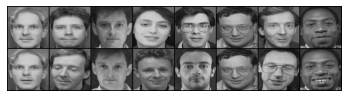

[[1. 0. 1. 0. 0. 1. 0. 1.]]


In [11]:
siamese_dataset.imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().T)

# Training

El modelo utilizado son dos redes neuronales

In [15]:
train_dl = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size= train_batch_size)

Creamos la red que vamos a usar y su configuración

In [10]:
config = {"l1":500, "l2":500, "threshold":0.7,"lr":0.0005}

net = SiameseNetwork(config)#.cuda()
trainer = pl.Trainer(max_epochs=20, progress_bar_refresh_rate=20)


GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [11]:
net

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

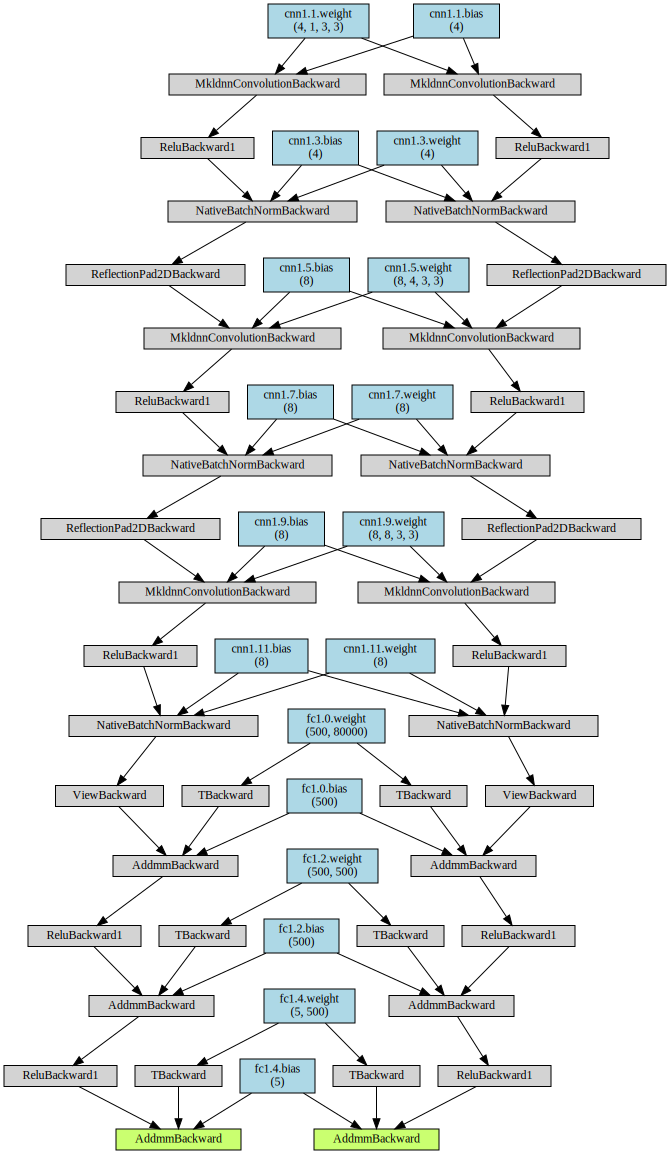

In [12]:
x0,x1,_,_,_ = next(iter(train_dl))
yhat = net(x0,x1) # Give dummy batch to forward().
make_dot(yhat, params=dict(list(net.named_parameters())))#.render("rnn_torchviz", format="png")


In [13]:
# Metodología sin pytorch lightning
#counter, loss_history =train_network(net, train_dl,iteration_step=10,train_number_epochs = 20)
#show_plot(counter,loss_history)

Realizamos el training usando mlflow para ir guardando los modelos generados

In [21]:
LIGHT_DIR = "lightning_logs"

In [15]:
mlflow.pytorch.autolog()

with mlflow.start_run(tags={"model":"facenet"}) as run:    
    trainer.fit(net,train_dl)
    mlflow.log_artifact(LIGHT_DIR)
    mlflow.log_params(config)




  | Name | Type       | Params
------------------------------------
0 | cnn1 | Sequential | 960   
1 | fc1  | Sequential | 40.3 M
------------------------------------
40.3 M    Trainable params
0         Non-trainable params
40.3 M    Total params
161.018   Total estimated model params size (MB)
INFO:lightning:
  | Name | Type       | Params
------------------------------------
0 | cnn1 | Sequential | 960   
1 | fc1  | Sequential | 40.3 M
------------------------------------
40.3 M    Trainable params
0         Non-trainable params
40.3 M    Total params
161.018   Total estimated model params size (MB)


Epoch 0:  34%|███▍      | 20/59 [00:15<00:30,  1.27it/s]      
Validating: 0it [00:00, ?it/s]
Epoch 1:  34%|███▍      | 20/59 [00:17<00:34,  1.12it/s, loss=5.79, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  34%|███▍      | 20/59 [00:17<00:33,  1.15it/s, loss=3.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  34%|███▍      | 20/59 [00:17<00:33,  1.17it/s, loss=2.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  34%|███▍      | 20/59 [00:16<00:33,  1.18it/s, loss=1.79, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  34%|███▍      | 20/59 [00:18<00:35,  1.09it/s, loss=1.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  34%|███▍      | 20/59 [00:19<00:37,  1.03it/s, loss=1.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  34%|███▍      | 20/59 [00:16<00:31,  1.24it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  34%|███▍      | 20/59 [00:19<00:38,  1.03it/s, loss=1.43, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  34%|███▍      | 20/59 [00:14<00:

In [17]:

shutil.rmtree(LIGHT_DIR)

In [18]:
print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))


run_id: e895f4175343469c9f6bf04fb34bc5d9
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data']
params: {'betas': '(0.9, 0.999)', 'weight_decay': '0', 'l2': '500', 'threshold': '0.7', 'amsgrad': 'False', 'epochs': '20', 'eps': '1e-08', 'optimizer_name': 'Adam', 'l1': '500', 'lr': '0.0005'}
metrics: {'train_acc': 0.6000000238418579, 'train_acc_step': 0.6000000238418579, 'train_acc_epoch': 0.5972973108291626, 'train_loss_step': 1.0900747776031494, 'train_loss': 1.0900747776031494, 'train_loss_epoch': 1.3889951705932617, 'ptl/val_loss': 1.3827834129333496, 'ptl/val_accuracy': 0.5}
tags: {'Mode': 'training', 'model': 'facenet'}


In [19]:
# Tensorboard log dir
os.path.join(run.info.artifact_uri,LIGHT_DIR)

'/home/pvanbranteghen/workspace/04_master-ia-avanzado/clases/03_aprendizaje-profundo-2/project/ssnetworks/models/mlruns/0/e895f4175343469c9f6bf04fb34bc5d9/artifacts/lightning_logs'

In [20]:
%tensorboard --logdir /home/pvanbranteghen/workspace/04_master-ia-avanzado/clases/03_aprendizaje-profundo-2/project/ssnetworks/models/mlruns/0/e895f4175343469c9f6bf04fb34bc5d9/artifacts/lightning_logs

## Testing
Probamos ahora con nuevos datos. Elegimos una imagen base y sobre ella evaluamos la disimilaridad. Creamos un iterador de los datos de test y elegimos una imagen base para evaluar visualmente el modelo

In [21]:
folder_dataset_test = dset.ImageFolder(root=DATA_TEST_DIR)
siamese_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dl = DataLoader(siamese_test,num_workers=6,batch_size=1,shuffle=True)


Elegimos imagen base

In [22]:
idx = siamese_test.get_idx_from_folder_name()[0]
x0 = siamese_test[30][0].unsqueeze(0)

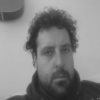

In [23]:
transforms.ToPILImage()(siamese_test[30][0])

Creamos las funciones de predicción y las realizamos

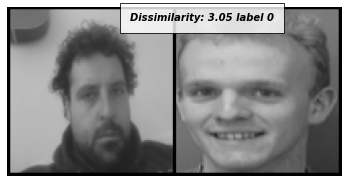

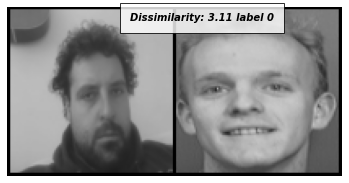

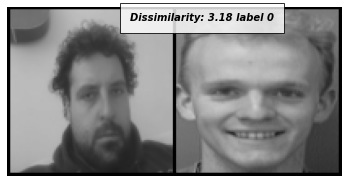

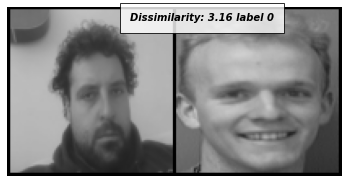

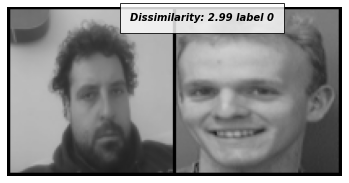

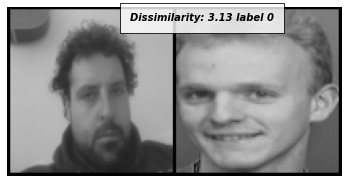

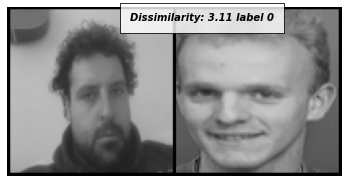

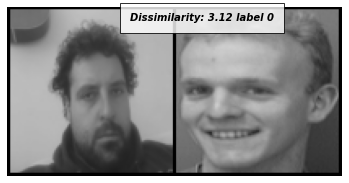

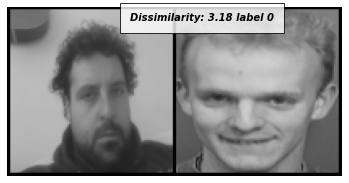

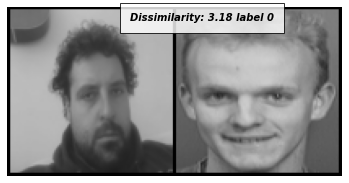

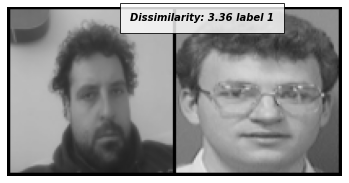

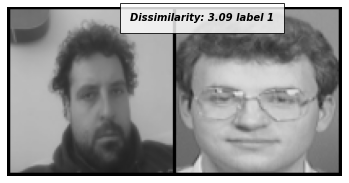

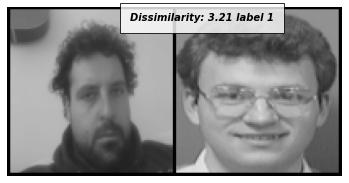

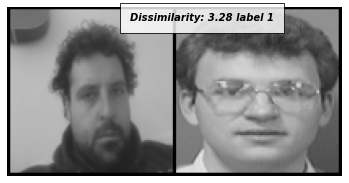

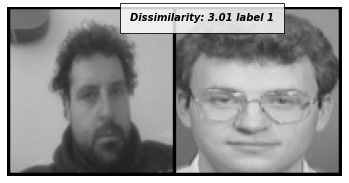

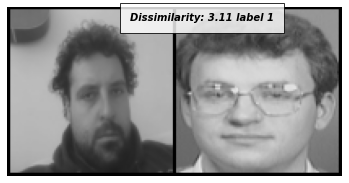

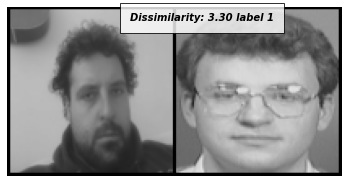

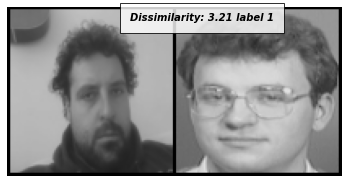

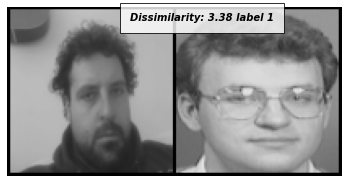

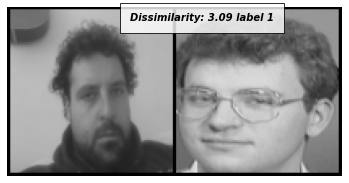

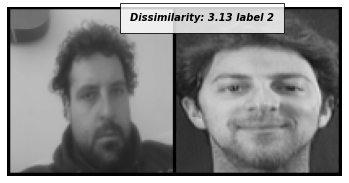

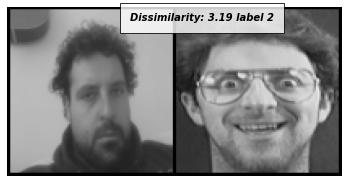

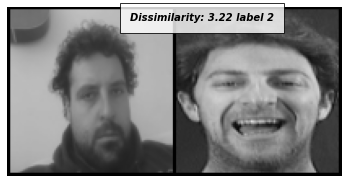

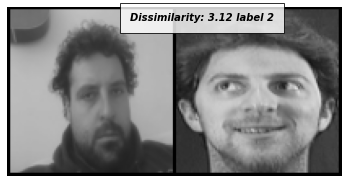

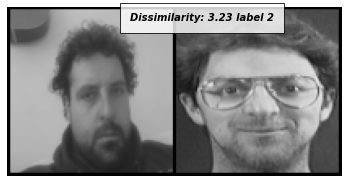

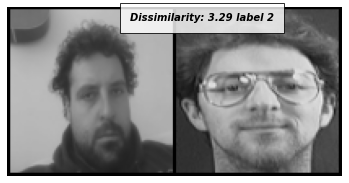

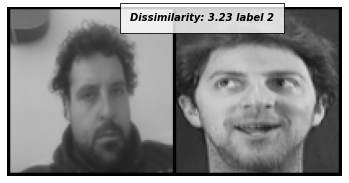

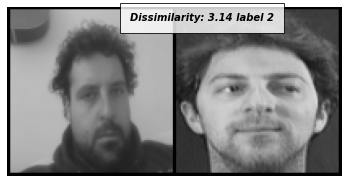

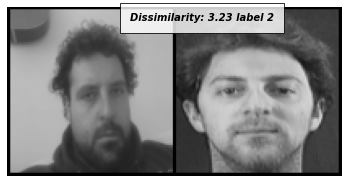

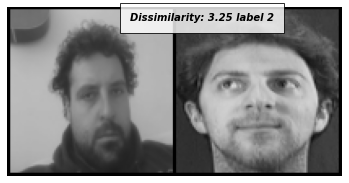

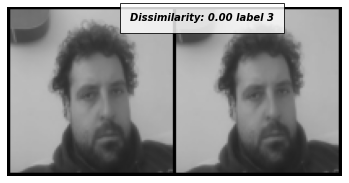

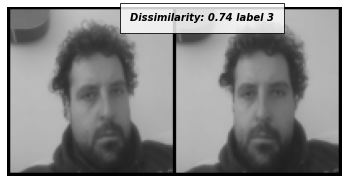

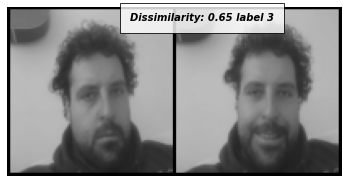

In [24]:
loaded_model = load_model(run.info.run_id) 
disim,label_2 = predict_over_dataset(loaded_model,siamese_test,x0,plot=True)

In [25]:
import pandas as pd
df_results = pd.DataFrame.from_dict({"score":disim, "label":label_2 })

<AxesSubplot:xlabel='label'>

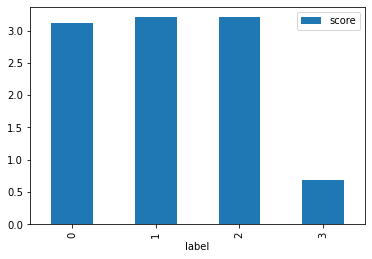

In [26]:
df_results[df_results.score>0.01].groupby("label").mean().plot(kind="bar")

Vemos como para el grupo 3, de donde procede la foto, los scores son mucho menores

## NETWORK 2

Probamos una segunda red neuronal con una configuracion diferente a la primera

In [12]:
config = {"l1":500, "l2":500, "threshold":0.7,"lr":0.0005}

net2 = SiameseNetworkV2(config)


In [13]:
net2

SiameseNetworkV2(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): ReLU(inplace=True)
    (7): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.3, inplace=False)
    (10): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=25600,

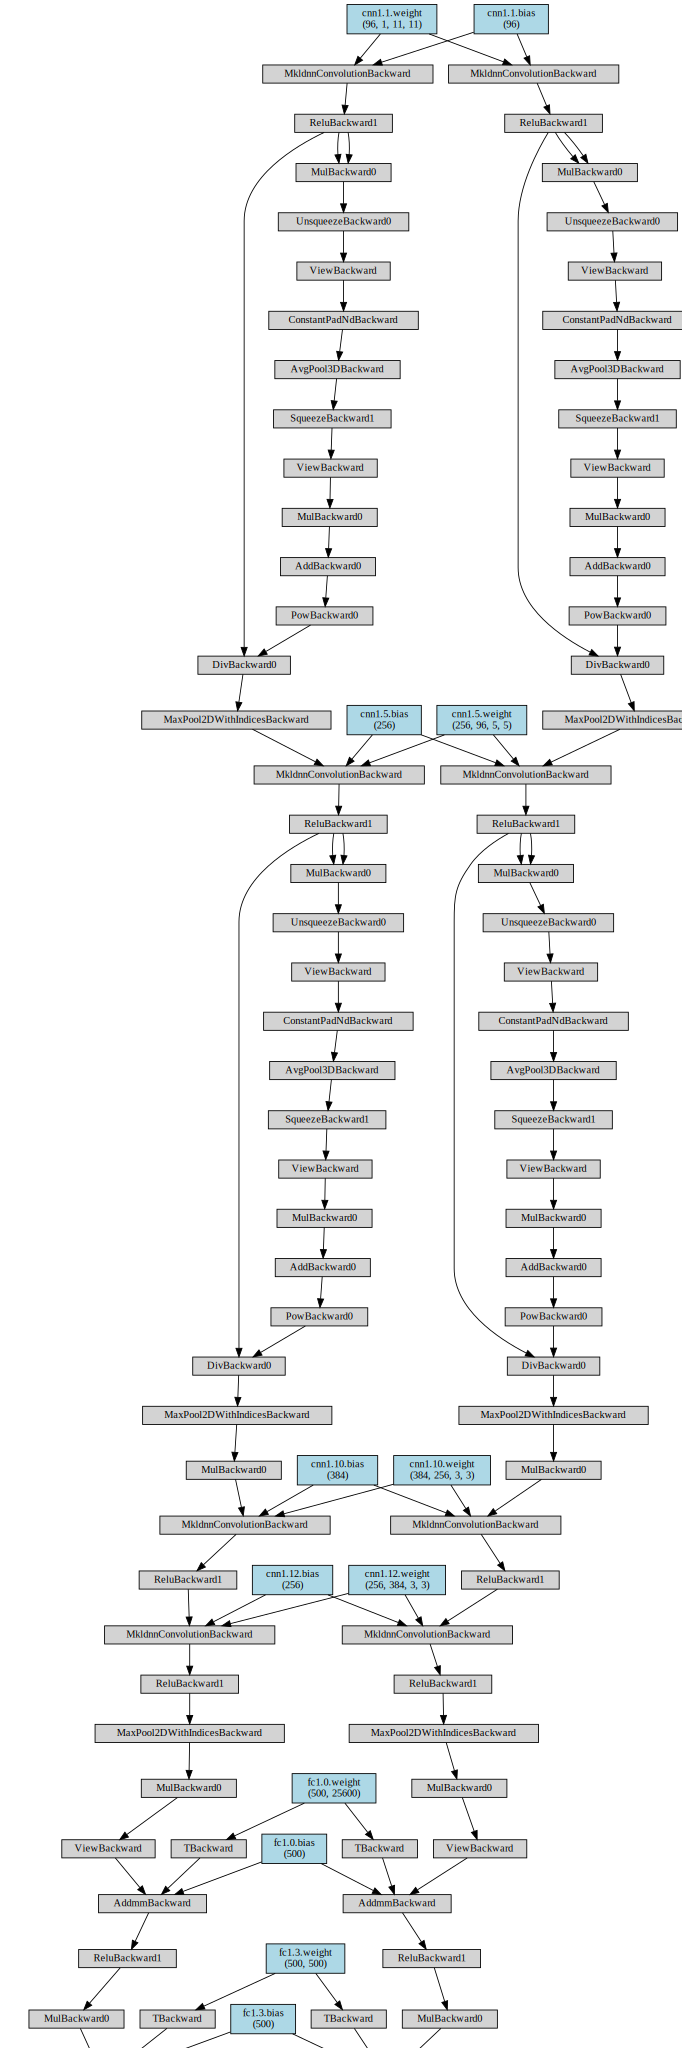

In [16]:
x0,x1,_,_,_ = next(iter(train_dl))
yhat = net2(x0,x1) # Give dummy batch to forward().
make_dot(yhat, params=dict(list(net2.named_parameters())))#.render("rnn_torchviz", format="png")


In [17]:
trainer = pl.Trainer(max_epochs=20, progress_bar_refresh_rate=20)


GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [18]:

# Train the model
with mlflow.start_run(tags={"model":"svsig"}) as run:
    trainer.fit(net2, train_dl)
    mlflow.log_artifact("lightning_logs")



  | Name | Type       | Params
------------------------------------
0 | cnn1 | Sequential | 2.4 M 
1 | fc1  | Sequential | 13.1 M
------------------------------------
15.4 M    Trainable params
0         Non-trainable params
15.4 M    Total params
61.800    Total estimated model params size (MB)


Epoch 0:  34%|███▍      | 20/59 [01:27<02:51,  4.39s/it]      
Validating: 0it [00:00, ?it/s]
Epoch 1:  34%|███▍      | 20/59 [01:34<03:03,  4.71s/it, loss=1.52, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 2:  34%|███▍      | 20/59 [01:25<02:47,  4.29s/it, loss=1.23, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 3:  34%|███▍      | 20/59 [01:34<03:05,  4.75s/it, loss=1.14, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 4:  34%|███▍      | 20/59 [01:32<03:00,  4.62s/it, loss=1.17, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 5:  34%|███▍      | 20/59 [01:19<02:34,  3.96s/it, loss=1.17, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 6:  34%|███▍      | 20/59 [01:31<02:59,  4.59s/it, loss=1.15, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 7:  34%|███▍      | 20/59 [01:28<02:53,  4.44s/it, loss=1.14, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 8:  34%|███▍      | 20/59 [01:38<03:11,  4.91s/it, loss=1.12, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 9:  34%|███▍      | 20/59 [01:37<03:

Eliminamos el lightning dir que por un bug se mantiene en el directorio de los notebooks y se duplica en el mlflow tracking

In [22]:
shutil.rmtree(LIGHT_DIR)

Vemos donde se ha guardado el artifact para ejecutar el tensorboard

In [23]:
os.path.join(run.info.artifact_uri,LIGHT_DIR)

'/home/pvanbranteghen/workspace/04_master-ia-avanzado/clases/03_aprendizaje-profundo-2/project/ssnetworks/models/mlruns/0/25ae99065acf4d1a8ef167667b96c028/artifacts/lightning_logs'

In [24]:
%tensorboard --logdir '/home/pvanbranteghen/workspace/04_master-ia-avanzado/clases/03_aprendizaje-profundo-2/project/ssnetworks/models/mlruns/0/25ae99065acf4d1a8ef167667b96c028/artifacts/lightning_logs'


tensor([0.7675], grad_fn=<NormBackward1>)


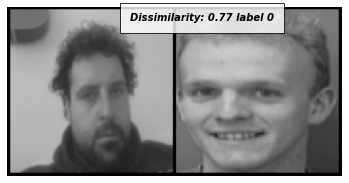

tensor([0.8133], grad_fn=<NormBackward1>)


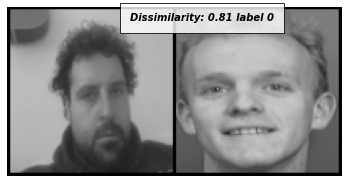

tensor([1.1153], grad_fn=<NormBackward1>)


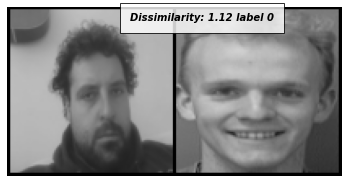

tensor([1.1928], grad_fn=<NormBackward1>)


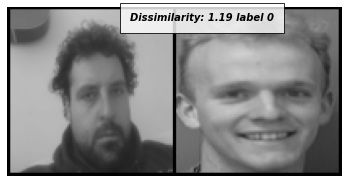

tensor([0.6518], grad_fn=<NormBackward1>)


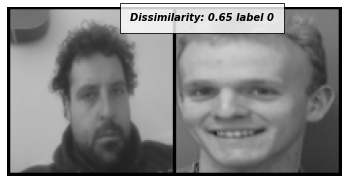

tensor([0.8308], grad_fn=<NormBackward1>)


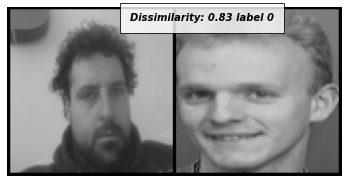

tensor([0.3305], grad_fn=<NormBackward1>)


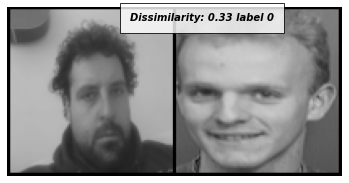

tensor([1.3708], grad_fn=<NormBackward1>)


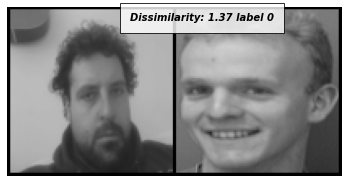

tensor([0.8501], grad_fn=<NormBackward1>)


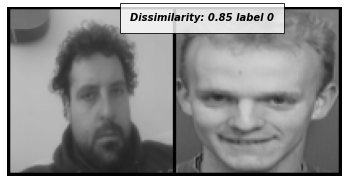

tensor([0.6158], grad_fn=<NormBackward1>)


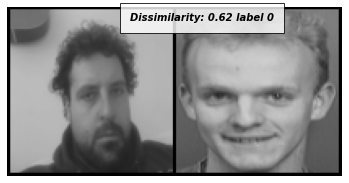

tensor([0.8733], grad_fn=<NormBackward1>)


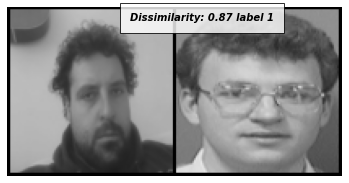

tensor([0.8711], grad_fn=<NormBackward1>)


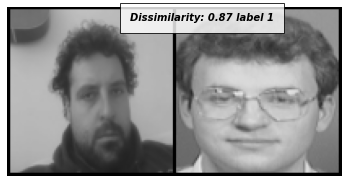

tensor([0.8110], grad_fn=<NormBackward1>)


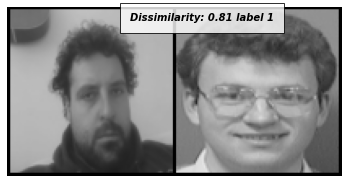

tensor([0.9703], grad_fn=<NormBackward1>)


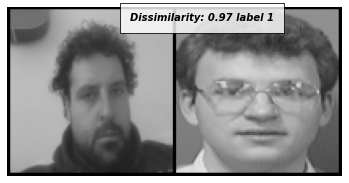

tensor([0.6896], grad_fn=<NormBackward1>)


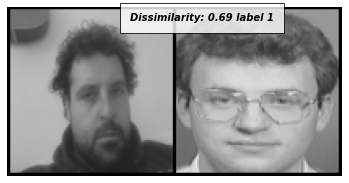

tensor([0.8941], grad_fn=<NormBackward1>)


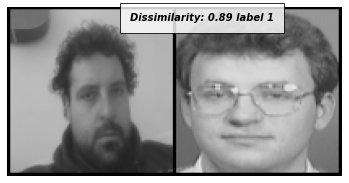

tensor([0.7725], grad_fn=<NormBackward1>)


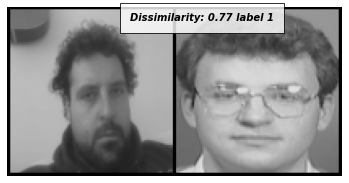

tensor([0.7281], grad_fn=<NormBackward1>)


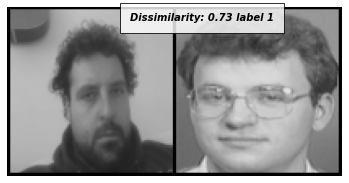

tensor([1.1108], grad_fn=<NormBackward1>)


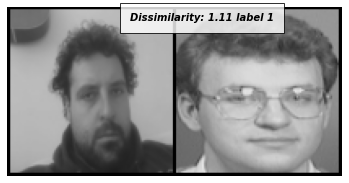

tensor([1.1318], grad_fn=<NormBackward1>)


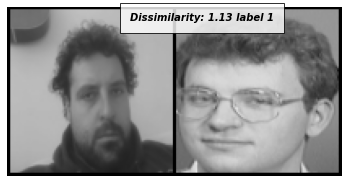

tensor([0.5113], grad_fn=<NormBackward1>)


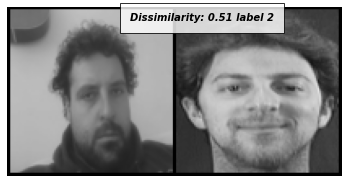

tensor([0.8595], grad_fn=<NormBackward1>)


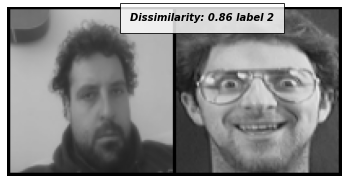

tensor([1.5108], grad_fn=<NormBackward1>)


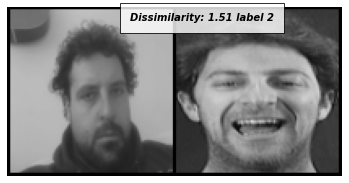

tensor([1.1745], grad_fn=<NormBackward1>)


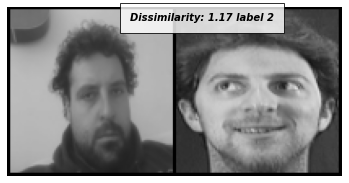

tensor([0.8473], grad_fn=<NormBackward1>)


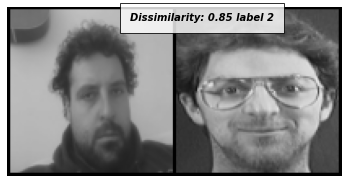

tensor([0.2183], grad_fn=<NormBackward1>)


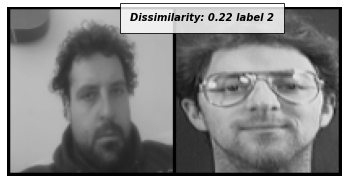

tensor([1.6807], grad_fn=<NormBackward1>)


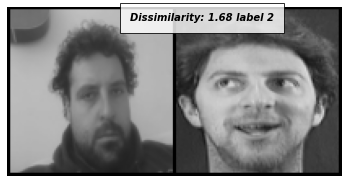

tensor([0.7658], grad_fn=<NormBackward1>)


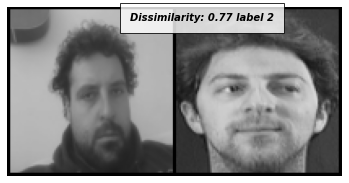

tensor([0.8935], grad_fn=<NormBackward1>)


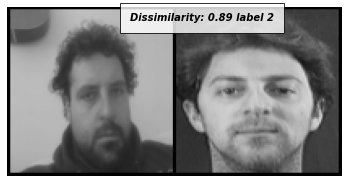

tensor([1.1315], grad_fn=<NormBackward1>)


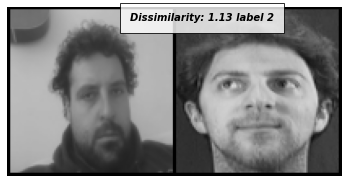

tensor([1.4288], grad_fn=<NormBackward1>)


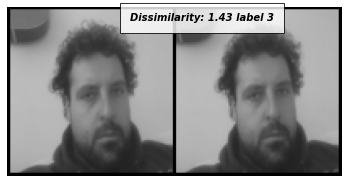

tensor([0.8298], grad_fn=<NormBackward1>)


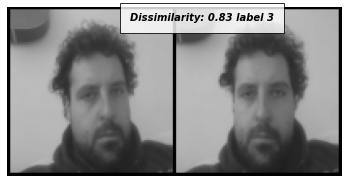

tensor([1.2855], grad_fn=<NormBackward1>)


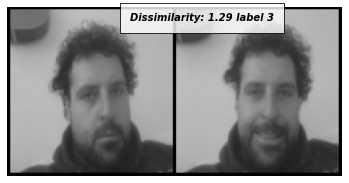

In [57]:
disim,label_2 = predict_over_dataset(net2,siamese_test,x0,plot=True)

Debido a los tiempos de entrenamiento de este modelo, mantenemos el anterior y iteramos sobre el mismo para evaluar los hiperparámetros

# Hyperparameter tunning
Hacemos un Hyperparameter tunning para ver la mejor configuración para el primer modelo

In [58]:
analysis = tune_ss(folder_dataset,train_batch_size=train_batch_size)

== Status ==
Memory usage on this node: 11.9/15.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1/8 CPUs, 0/0 GPUs, 0.0/1.66 GiB heap, 0.0/0.54 GiB objects
Result logdir: /home/pvanbranteghen/ray_results/tune_ss
Number of trials: 1/10 (1 RUNNING)
+--------------------+----------+-------+------+------+-----------+
| Trial name         | status   | loc   |   l1 |   l2 |        lr |
|--------------------+----------+-------+------+------+-----------|
| _inner_7a111_00000 | RUNNING  |       |   64 |  256 | 0.0274138 |
+--------------------+----------+-------+------+------+-----------+




(pid=3944392) GPU available: False, used: False
(pid=3944392) INFO:lightning:GPU available: False, used: False
(pid=3944392) TPU available: None, using: 0 TPU cores
(pid=3944392) INFO:lightning:TPU available: None, using: 0 TPU cores
(pid=3944392) 
(pid=3944392)   | Name | Type       | Params
(pid=3944392) ------------------------------------
(pid=3944392) 0 | cnn1 | Sequential | 960   
(pid=3944392) 1 | fc1  | Sequential | 5.1 M 
(pid=3944392) ------------------------------------
(pid=3944392) 5.1 M     Trainable params
(pid=3944392) 0         Non-trainable params
(pid=3944392) 5.1 M     Total params
(pid=3944392) 20.556    Total estimated model params size (MB)
(pid=3944392) INFO:lightning:
(pid=3944392)   | Name | Type       | Params
(pid=3944392) ------------------------------------
(pid=3944392) 0 | cnn1 | Sequential | 960   
(pid=3944392) 1 | fc1  | Sequential | 5.1 M 
(pid=3944392) ------------------------------------
(pid=3944392) 5.1 M     Trainable params
(pid=3944392) 0     

(pid=3960765) 
(pid=3960765)   | Name | Type       | Params
(pid=3960765) ------------------------------------
(pid=3960765) 0 | cnn1 | Sequential | 960   
(pid=3960765) 1 | fc1  | Sequential | 10.3 M
(pid=3960765) ------------------------------------
(pid=3960765) 10.3 M    Trainable params
(pid=3960765) 0         Non-trainable params
(pid=3960765) 10.3 M    Total params
(pid=3960765) 41.102    Total estimated model params size (MB)
(pid=3960765) INFO:lightning:
(pid=3960765)   | Name | Type       | Params
(pid=3960765) ------------------------------------
(pid=3960765) 0 | cnn1 | Sequential | 960   
(pid=3960765) 1 | fc1  | Sequential | 10.3 M
(pid=3960765) ------------------------------------
(pid=3960765) 10.3 M    Trainable params
(pid=3960765) 0         Non-trainable params
(pid=3960765) 10.3 M    Total params
(pid=3960765) 41.102    Total estimated model params size (MB)


Result for _inner_7a111_00000:
  date: 2021-03-04_16-02-00
  done: false
  experiment_id: 3eddaffe09294827a72721d7167d0a28
  hostname: pvanbranteghen
  iterations_since_restore: 1
  loss: 545860.8125
  mean_accuracy: 0.5249999761581421
  node_ip: 192.168.1.138
  pid: 3944392
  time_since_restore: 35.06743383407593
  time_this_iter_s: 35.06743383407593
  time_total_s: 35.06743383407593
  timestamp: 1614870120
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a111_00000
  
== Status ==
Memory usage on this node: 14.5/15.3 GiB: ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -545860.8125
Resources requested: 8/8 CPUs, 0/0 GPUs, 0.0/1.66 GiB heap, 0

Result for _inner_7a111_00003:
  date: 2021-03-04_16-02-18
  done: true
  experiment_id: c893aaa5c50345e38f324baa5b725baf
  hostname: pvanbranteghen
  iterations_since_restore: 1
  loss: 12472.322265625
  mean_accuracy: 0.6000000238418579
  node_ip: 192.168.1.138
  pid: 3960767
  time_since_restore: 52.41213417053223
  time_this_iter_s: 52.41213417053223
  time_total_s: 52.41213417053223
  timestamp: 1614870138
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a111_00003
  
Result for _inner_7a111_00007:
  date: 2021-03-04_16-02-19
  done: false
  experiment_id: 136645073e6d4a0a90aede852fddbe95
  hostname: pvanbranteghen
  iterations_since_restore: 1
  loss: 1.7004261016845703
  mean_accuracy: 0.7250000238418579
  node_ip: 192.168.1.138
  pid: 3960778
  time_since_restore: 52.84922385215759
  time_this_iter_s: 52.84922385215759
  time_total_s: 52.84922385215759
  timestamp: 1614870139
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a111_00007
  
Result

(pid=3962585) GPU available: False, used: False
(pid=3962585) INFO:lightning:GPU available: False, used: False
(pid=3962585) TPU available: None, using: 0 TPU cores
(pid=3962585) INFO:lightning:TPU available: None, using: 0 TPU cores
(pid=3962662) GPU available: False, used: False
(pid=3962662) INFO:lightning:GPU available: False, used: False
(pid=3962662) TPU available: None, using: 0 TPU cores
(pid=3962662) INFO:lightning:TPU available: None, using: 0 TPU cores
(pid=3962585) 
(pid=3962585)   | Name | Type       | Params
(pid=3962585) ------------------------------------
(pid=3962585) 0 | cnn1 | Sequential | 960   
(pid=3962585) 1 | fc1  | Sequential | 10.3 M
(pid=3962585) ------------------------------------
(pid=3962585) 10.3 M    Trainable params
(pid=3962585) 0         Non-trainable params
(pid=3962585) 10.3 M    Total params
(pid=3962585) 41.033    Total estimated model params size (MB)
(pid=3962585) INFO:lightning:
(pid=3962585)   | Name | Type       | Params
(pid=3962585) -----

Result for _inner_7a111_00002:
  date: 2021-03-04_16-03-07
  done: false
  experiment_id: f4c80466e3424daca9111940dde13bce
  hostname: pvanbranteghen
  iterations_since_restore: 2
  loss: 5.13060998916626
  mean_accuracy: 0.800000011920929
  node_ip: 192.168.1.138
  pid: 3960771
  time_since_restore: 101.38142561912537
  time_this_iter_s: 49.56638312339783
  time_total_s: 101.38142561912537
  timestamp: 1614870187
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 7a111_00002
  
== Status ==
Memory usage on this node: 13.8/15.3 GiB: ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: -5.13060998916626 | Iter 1.000: -9.171876907348633
Resources requested: 8/8 CPUs, 0/0 G

Result for _inner_7a111_00004:
  date: 2021-03-04_16-03-20
  done: false
  experiment_id: cc23cc0ae48e469fbe82da2157a5a516
  hostname: pvanbranteghen
  iterations_since_restore: 3
  loss: 1.7341444492340088
  mean_accuracy: 0.6000000238418579
  node_ip: 192.168.1.138
  pid: 3960769
  time_since_restore: 114.41817831993103
  time_this_iter_s: 39.833223819732666
  time_total_s: 114.41817831993103
  timestamp: 1614870200
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 7a111_00004
  
Result for _inner_7a111_00008:
  date: 2021-03-04_16-03-44
  done: false
  experiment_id: 715f5b91e33f4243add4a4d87a2f4903
  hostname: pvanbranteghen
  iterations_since_restore: 1
  loss: 2.299994945526123
  mean_accuracy: 0.574999988079071
  node_ip: 192.168.1.138
  pid: 3962585
  time_since_restore: 53.797847509384155
  time_this_iter_s: 53.797847509384155
  time_total_s: 53.797847509384155
  timestamp: 1614870224
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a111_00008
 

Result for _inner_7a111_00006:
  date: 2021-03-04_16-03-59
  done: false
  experiment_id: aa5154ca355c4618b364d076eaf61185
  hostname: pvanbranteghen
  iterations_since_restore: 3
  loss: 1.715041160583496
  mean_accuracy: 0.6499999761581421
  node_ip: 192.168.1.138
  pid: 3960773
  time_since_restore: 152.64389419555664
  time_this_iter_s: 48.71989464759827
  time_total_s: 152.64389419555664
  timestamp: 1614870239
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 7a111_00006
  
Result for _inner_7a111_00007:
  date: 2021-03-04_16-04-00
  done: false
  experiment_id: 136645073e6d4a0a90aede852fddbe95
  hostname: pvanbranteghen
  iterations_since_restore: 3
  loss: 1.4385006427764893
  mean_accuracy: 0.574999988079071
  node_ip: 192.168.1.138
  pid: 3960778
  time_since_restore: 153.78850030899048
  time_this_iter_s: 49.76507329940796
  time_total_s: 153.78850030899048
  timestamp: 1614870240
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 7a111_00007
  


Result for _inner_7a111_00004:
  date: 2021-03-04_16-04-42
  done: false
  experiment_id: cc23cc0ae48e469fbe82da2157a5a516
  hostname: pvanbranteghen
  iterations_since_restore: 6
  loss: 1.3488547801971436
  mean_accuracy: 0.550000011920929
  node_ip: 192.168.1.138
  pid: 3960769
  time_since_restore: 196.4458065032959
  time_this_iter_s: 20.64162015914917
  time_total_s: 196.4458065032959
  timestamp: 1614870282
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 7a111_00004
  
== Status ==
Memory usage on this node: 12.0/15.3 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: None | Iter 4.000: -1.2227098941802979 | Iter 2.000: -1.9730268716812134 | Iter 1.000: -9.47166132926941
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/1.66 GiB heap, 0.0/0.54 GiB objects
Current best trial: 7a111_00007 with loss=1.096555471420288 and parameters={'l1': 128, 'l2': 256, 'lr': 0.00017172877031599324}
Result logdir: /home/pvanbranteghen/ray_results/tune_ss
Number of trials: 10/

Result for _inner_7a111_00004:
  date: 2021-03-04_16-05-04
  done: false
  experiment_id: cc23cc0ae48e469fbe82da2157a5a516
  hostname: pvanbranteghen
  iterations_since_restore: 7
  loss: 1.3515617847442627
  mean_accuracy: 0.574999988079071
  node_ip: 192.168.1.138
  pid: 3960769
  time_since_restore: 218.2271614074707
  time_this_iter_s: 21.781354904174805
  time_total_s: 218.2271614074707
  timestamp: 1614870304
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 7a111_00004
  
Result for _inner_7a111_00002:
  date: 2021-03-04_16-05-23
  done: false
  experiment_id: f4c80466e3424daca9111940dde13bce
  hostname: pvanbranteghen
  iterations_since_restore: 6
  loss: 1.2917258739471436
  mean_accuracy: 0.550000011920929
  node_ip: 192.168.1.138
  pid: 3960771
  time_since_restore: 237.65819644927979
  time_this_iter_s: 28.023695707321167
  time_total_s: 237.65819644927979
  timestamp: 1614870323
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 7a111_00002
  


Result for _inner_7a111_00002:
  date: 2021-03-04_16-05-51
  done: false
  experiment_id: f4c80466e3424daca9111940dde13bce
  hostname: pvanbranteghen
  iterations_since_restore: 7
  loss: 1.2635279893875122
  mean_accuracy: 0.550000011920929
  node_ip: 192.168.1.138
  pid: 3960771
  time_since_restore: 265.47365832328796
  time_this_iter_s: 27.81546187400818
  time_total_s: 265.47365832328796
  timestamp: 1614870351
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 7a111_00002
  
== Status ==
Memory usage on this node: 12.8/15.3 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -1.511418104171753 | Iter 4.000: -1.2227098941802979 | Iter 2.000: -1.9730268716812134 | Iter 1.000: -9.47166132926941
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/1.66 GiB heap, 0.0/0.54 GiB objects
Current best trial: 7a111_00006 with loss=1.25196373462677 and parameters={'l1': 128, 'l2': 128, 'lr': 0.0009760646424383691}
Result logdir: /home/pvanbranteghen/ray_results/tune_ss
Number 

Result for _inner_7a111_00002:
  date: 2021-03-04_16-06-18
  done: false
  experiment_id: f4c80466e3424daca9111940dde13bce
  hostname: pvanbranteghen
  iterations_since_restore: 8
  loss: 1.2968641519546509
  mean_accuracy: 0.6499999761581421
  node_ip: 192.168.1.138
  pid: 3960771
  time_since_restore: 292.1226236820221
  time_this_iter_s: 26.64896535873413
  time_total_s: 292.1226236820221
  timestamp: 1614870378
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 7a111_00002
  
== Status ==
Memory usage on this node: 11.6/15.3 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -1.404141128063202 | Iter 4.000: -1.2227098941802979 | Iter 2.000: -1.9730268716812134 | Iter 1.000: -9.47166132926941
Resources requested: 3/8 CPUs, 0/0 GPUs, 0.0/1.66 GiB heap, 0.0/0.54 GiB objects
Current best trial: 7a111_00004 with loss=1.1472994089126587 and parameters={'l1': 64, 'l2': 256, 'lr': 0.000502649658979765}
Result logdir: /home/pvanbranteghen/ray_results/tune_ss
Number o

2021-03-04 16:06:54,820	INFO tune.py:450 -- Total run time: 335.17 seconds (335.15 seconds for the tuning loop).


Result for _inner_7a111_00002:
  date: 2021-03-04_16-06-54
  done: true
  experiment_id: f4c80466e3424daca9111940dde13bce
  hostname: pvanbranteghen
  iterations_since_restore: 10
  loss: 1.2285780906677246
  mean_accuracy: 0.5
  node_ip: 192.168.1.138
  pid: 3960771
  time_since_restore: 328.5665063858032
  time_this_iter_s: 17.04334044456482
  time_total_s: 328.5665063858032
  timestamp: 1614870414
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 7a111_00002
  
== Status ==
Memory usage on this node: 10.0/15.3 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -1.4880309104919434 | Iter 4.000: -1.2227098941802979 | Iter 2.000: -1.9730268716812134 | Iter 1.000: -9.47166132926941
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/1.66 GiB heap, 0.0/0.54 GiB objects
Current best trial: 7a111_00004 with loss=1.1472994089126587 and parameters={'l1': 64, 'l2': 256, 'lr': 0.000502649658979765}
Result logdir: /home/pvanbranteghen/ray_results/tune_ss
Number of trials: 10

In [59]:
analysis.best_config

{'l1': 64, 'l2': 256, 'lr': 0.000502649658979765, 'threshold': 0.7}

# Productivización

Debido a que hemos usado MLFLow, podemos productivizar el modelo como una API y hacerle peticiones

Esta parte se realiza en el notebook 02.pvbl-testing-camera.ipynb, donde se pone la red a evaluar en tiempo real si dos imágenes son coincidentes